### Labwork 9

#### Мета - створити нейронну мережу, що здатна відрізнити кота і собаку.

Імпортуєм бібліотеки

In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import random

import os
print(os.listdir(r"C:\Users\Nono\Documents\Lab 9\Lab 9_2\dogs-vs-cats"))

['sampleSubmission.csv', 'test1.zip', 'train.zip']


Розпаковуєм файли

In [2]:
import zipfile

with zipfile.ZipFile(r"C:\Users\Nono\Documents\Lab 9\Lab 9_2\dogs-vs-cats/train.zip","r") as z:
    z.extractall(".")
    
with zipfile.ZipFile(r"C:\Users\Nono\Documents\Lab 9\Lab 9_2\dogs-vs-cats/test1.zip","r") as z:
    z.extractall(".")

Отримання списку каталогів в кожній папці

In [3]:
DIR_TRAIN = r"C:\Users\Nono\Documents\Lab 9\Lab 9_2\train"
DIR_TEST = r"C:\Users\Nono\Documents\Lab 9\Lab 9_2\test1"

train_imgs = os.listdir(DIR_TRAIN)
test_imgs = os.listdir(DIR_TEST)

Кількість данних

In [4]:
print(len(os.listdir(r"C:\Users\Nono\Documents\Lab 9\Lab 9_2\train")), 'training data')
print(len(os.listdir(r"C:\Users\Nono\Documents\Lab 9\Lab 9_2\test1")), 'test data')

25000 training data
12500 test data


In [5]:
os.listdir(r"C:\Users\Nono\Documents\Lab 9\Lab 9_2\train")[:5]

['cat.0.jpg', 'cat.1.jpg', 'cat.10.jpg', 'cat.100.jpg', 'cat.1000.jpg']

Загрузка файла з зображенням тварини

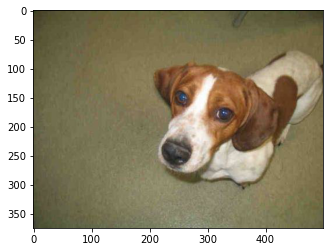

In [6]:
sample = random.choice(train_imgs) # обираєм випадковий файл із зображенням
image = load_img("C:/Users/Nono/Documents/Lab 9/Lab 9_2/train/"+sample) # отримуєм назву обраного файлу
plt.imshow(image)
plt.show()

Створюєм DataFrame для тренувального набору

In [7]:
category = [x.split(".")[0] for x in train_imgs]
df = pd.DataFrame({"Filename":train_imgs, "Category":category})
df.head()

,Filename,Category
0,cat.0.jpg,cat
1,cat.1.jpg,cat
2,cat.10.jpg,cat
3,cat.100.jpg,cat
4,cat.1000.jpg,cat


Візуалізуєм співвідношення данних нашого тренувально набору

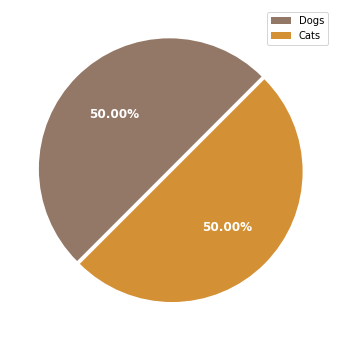

In [8]:
plt.figure(figsize=(6,6))
plt.pie(df['Category'].value_counts(), explode=[0.01,0.02], 
       autopct="%.2f%%", textprops={'color':'white', 'size':12,
                                   'weight':'bold'},
       startangle=45, colors = ['#947867', '#D49034'])
plt.legend(["Dogs","Cats"])
plt.show()

### Розділяєм дані на тренування та перевірку

Розподіл нашого train set на категорії в рівних частинах

In [9]:
df_train, df_valid = train_test_split(df, test_size = 5000, 
                                     stratify=df['Category'],
                                     random_state=42)

Перевіряєм чи кількість в категоріях рівна

In [10]:
df_train['Category'].value_counts()

dog    10000
cat    10000
Name: Category, dtype: int64

In [11]:
df_train.reset_index(drop=True, inplace=True)
df_valid.reset_index(drop=True, inplace=True)

#### Обробка даних


Data Augmentation (збільшення даних)

In [12]:
# Створення генератора для тренувального набору

train_datagen = ImageDataGenerator(
    rotation_range = 15,
    rescale = 1.0/255.0,
    zoom_range = 0.2,
    horizontal_flip = True,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
)

train_generator = train_datagen.flow_from_dataframe(df_train, 
                                  directory = "C:/Users/Nono/Documents/Lab 9/Lab 9_2/train/",
                                  x_col = 'Filename',
                                  y_col = 'Category',
                                  target_size = (224, 224),
                                  class_mode = 'categorical',
                                  batch_size = 32
                                 )

Found 20000 validated image filenames belonging to 2 classes.


In [13]:
# Створення генератора для перевірочного набору

valid_datagen = ImageDataGenerator(rescale = 1.0/255.0)

valid_generator = valid_datagen.flow_from_dataframe(df_valid, 
                                  directory = "C:/Users/Nono/Documents/Lab 9/Lab 9_2/train/",
                                  x_col = 'Filename',
                                  y_col = 'Category',
                                  target_size = (224, 224),
                                  class_mode = 'categorical',
                                  batch_size = 32
                                 )

Found 5000 validated image filenames belonging to 2 classes.


Подивимось як добре працює генератор

In [14]:
df_example = df_train.sample(1)

example_generator = train_datagen.flow_from_dataframe(df_example,
                                  directory = "C:/Users/Nono/Documents/Lab 9/Lab 9_2/train/",
                                  x_col = 'Filename',
                                  y_col = 'Category',
                                  target_size = (224, 224),
                                  class_mode = 'categorical')

Found 1 validated image filenames belonging to 1 classes.


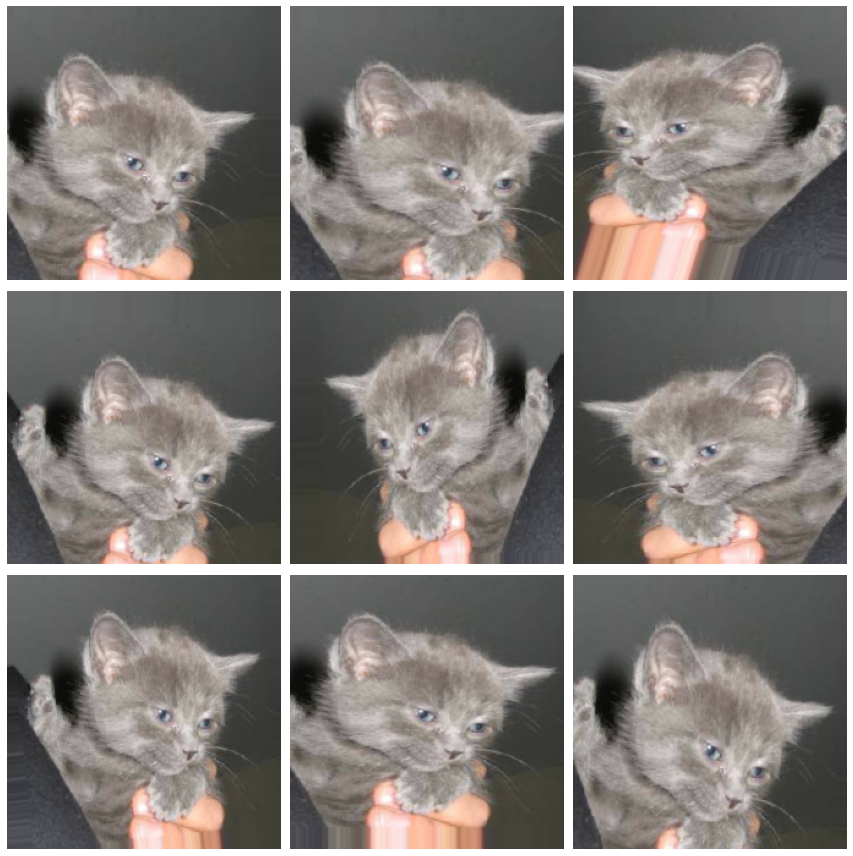

In [15]:
plt.figure(figsize=(12,12))

for i in range(9):
    plt.subplot(3, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        plt.axis("off")
        break
plt.tight_layout()
plt.show()

Працює, як і сподівалися)) !!

#### Створення моделі

Створення sequential model

In [16]:
from functools import partial

keras.backend.clear_session()


DefaultConv = partial(keras.layers.Conv2D, kernel_size = 3, strides = 1,
                     padding = 'same', activation = 'relu')

model = keras.models.Sequential([
    DefaultConv(filters = 32, kernel_size = 7, strides=2, input_shape=[224,224,3]),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=2),

    DefaultConv(filters = 64),
    DefaultConv(filters = 64),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.25),
    keras.layers.MaxPool2D(pool_size=2),
    
    DefaultConv(filters = 128),
    DefaultConv(filters = 128),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.25),
    keras.layers.MaxPool2D(pool_size=2),
    
    DefaultConv(filters = 256),
    DefaultConv(filters = 256),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.25),
    keras.layers.MaxPool2D(pool_size=2),
    
    DefaultConv(filters = 512),
    DefaultConv(filters = 512),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.4),
    keras.layers.MaxPool2D(pool_size=2),
    
    keras.layers.Flatten(),
    keras.layers.Dense(300, activation = 'relu', use_bias = False),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation = 'sigmoid')
])

model.compile(loss = "binary_crossentropy", optimizer = 'nadam',
             metrics = ['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 32)      4736      
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 56, 56, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 56, 56, 64)       2

callbacks (зворотні виклики)

In [18]:
Checkpoint_cb = keras.callbacks.ModelCheckpoint("model.h5", save_best_only=True)
Earlystopping_cb = keras.callbacks.EarlyStopping(patience=10)

callback = [Checkpoint_cb, Earlystopping_cb]

Fitting the model (підлаштування моделі)


In [22]:
history = model.fit(
    train_generator,
    epochs = 50,
    validation_data = valid_generator,
    validation_steps = len(df_valid)/32,
    steps_per_epoch = len(df_train)/32,
    callbacks=callback
)

Epoch 1/50
625/625 [==============================] - 767s 1s/step - loss: 0.6912 - accuracy: 0.6302 - val_loss: 0.9642 - val_accuracy: 0.5786
Epoch 2/50
625/625 [==============================] - 731s 1s/step - loss: 0.5822 - accuracy: 0.7081 - val_loss: 0.6850 - val_accuracy: 0.6676
Epoch 3/50
625/625 [==============================] - 732s 1s/step - loss: 0.5088 - accuracy: 0.7602 - val_loss: 0.7295 - val_accuracy: 0.6938
Epoch 4/50
625/625 [==============================] - 727s 1s/step - loss: 0.4396 - accuracy: 0.8033 - val_loss: 0.5019 - val_accuracy: 0.8252
Epoch 5/50
625/625 [==============================] - 750s 1s/step - loss: 0.3755 - accuracy: 0.8372 - val_loss: 0.6136 - val_accuracy: 0.7488
Epoch 6/50
625/625 [==============================] - 755s 1s/step - loss: 0.3337 - accuracy: 0.8605 - val_loss: 1.7223 - val_accuracy: 0.6394
Epoch 7/50
625/625 [==============================] - 761s 1s/step - loss: 0.2992 - accuracy: 0.8738 - val_loss: 0.2718 - val_accuracy: 0.8934

Візуалізація


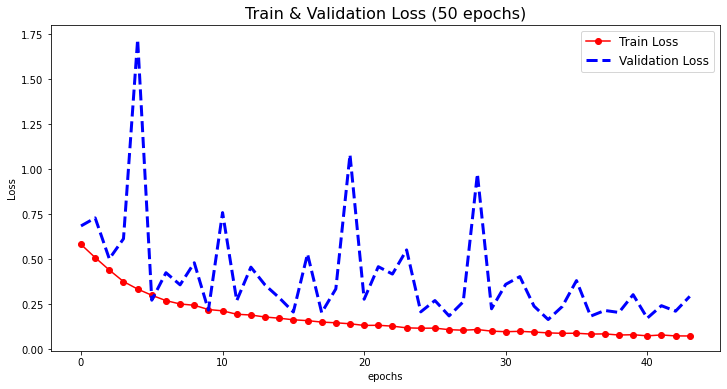

In [23]:
# Train and Validation Loss (втрати при тренуванні та перевірці)

plt.figure(figsize=(12,6))
plt.plot(history.history['loss'][1:], "ro-", label = "Train Loss")
plt.plot(history.history['val_loss'][1:], "b--", lw=3, label = "Validation Loss")
plt.legend(loc="upper right", fontsize=12)
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.title("Train & Validation Loss (50 epochs)", fontsize=16)
plt.show()

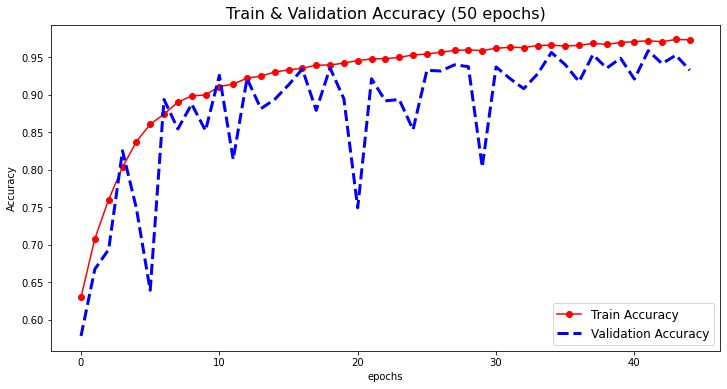

In [24]:
# Train and Validation Accuracy

plt.figure(figsize=(12,6))
plt.plot(history.history['accuracy'], "ro-", label = "Train Accuracy")
plt.plot(history.history['val_accuracy'], "b--", lw=3, label = "Validation Accuracy")
plt.legend(loc="lower right", fontsize=12)
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.title("Train & Validation Accuracy (50 epochs)", fontsize=16)
plt.show()

З графіку видно, що під час тренування відбувались деякі випадки перенавчання.
Загалом модель показала високі результати завдяки додаванню методів регуляризації, таких як DataAugmentaion, BatchNormalization і DropOut.

#### Обробка тестових даних


In [25]:
df_test = pd.DataFrame({'Filename':test_imgs})
df_test.head()

,Filename
0,1.jpg
1,10.jpg
2,100.jpg
3,1000.jpg
4,10000.jpg


Створення генератора

In [26]:
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

test_generator = test_datagen.flow_from_dataframe(
    df_test,
    directory = "C:/Users/Nono/Documents/Lab 9/Lab 9_2/test1/",
    x_col = 'Filename',
    y_col = None,
    class_mode = None,
    target_size = (224, 224),
    batch_size = 32,
    shuffle = False
)

Found 12500 validated image filenames.


In [27]:
# Загрузка найкращої моделі

model = keras.models.load_model("model.h5")

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 32)      4736      
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 56, 56, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 56, 56, 64)       2

#### Прогнозування

In [29]:
pred = model.predict(test_generator, 
                     steps = np.ceil(df_test.shape[0]/32))

Модель повертає ймовірність того, що екземпляр належить кожній категорії.

In [30]:
np.set_printoptions(suppress=True)

pred[:8]

array([[0.0000001 , 1.        ],
       [1.        , 0.        ],
       [0.44171754, 0.56224084],
       [0.        , 1.        ],
       [0.00081632, 0.9991522 ],
       [1.        , 0.00000005],
       [0.9999515 , 0.0000497 ],
       [0.        , 1.        ]], dtype=float32)

Ми додамо категорію до нашого фрейму даних на основі наших прогнозів.
Якщо перша ймовірність у кожному рядку більша за 0,5, ми визначаємо її як кішку, інакше собаку.

In [31]:
category = []
for x in pred[:,0]:
    category.append("cat" if x > 0.5 else "dog")
    
df_test['Category'] = category

df_test.head()

,Filename,Category
0,1.jpg,dog
1,10.jpg,cat
2,100.jpg,dog
3,1000.jpg,dog
4,10000.jpg,dog


#### Візуалізація наших прогнозів

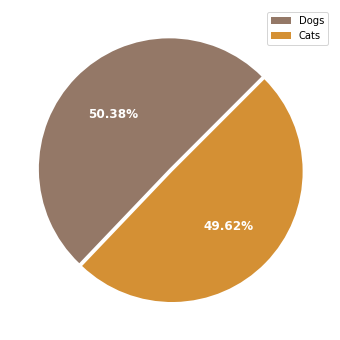

In [32]:
plt.figure(figsize=(6,6))
plt.pie(df_test['Category'].value_counts(), explode=[0.01,0.02], 
       autopct="%.2f%%", textprops={'color':'white', 'size':12,
                                   'weight':'bold'},
       startangle=45, colors = ['#947867', '#D49034'])
plt.legend(["Dogs","Cats"])
plt.show()

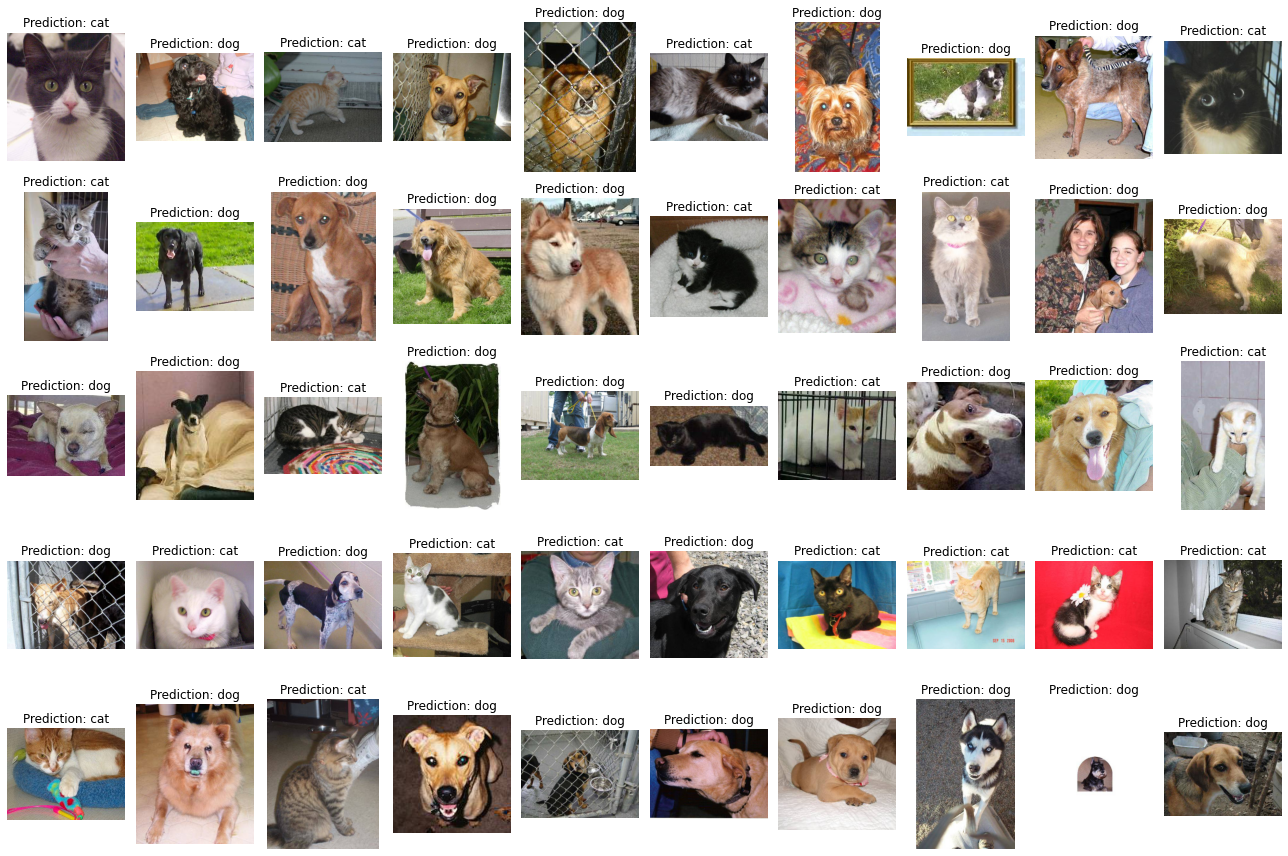

In [33]:
df_example = df_test.sample(50).reset_index(drop=True)

plt.figure(figsize=(18,12))

for i in range(50):
    plt.subplot(5,10,i+1)
    filename = df_example['Filename'][i]
    category = df_example['Category'][i]
    image = load_img('C:/Users/Nono/Documents/Lab 9/Lab 9_2/test1/'+filename)
    plt.imshow(image)
    plt.title(f"Prediction: {category}")
    plt.axis("off")
plt.tight_layout()
plt.show()

В файл, для збереження зпрогнозованих результатів, подаєм ймовірність того, що зображення є собакою.
Для цього берем другий стовпець нашої змінної pred.

In [34]:
df_result = df_test.copy()
df_result['Category'] = pred[:,1]
df_result['id'] = df_result['Filename'].str.split('.').str[0]
df_result['label'] = df_result['Category']
df_result.drop(['Filename', 'Category'], axis = 1, inplace = True)
df_result.to_csv('result.csv', index=False)

In [35]:
df_result

,id,label
0,1,1.000000e+00
1,10,4.143269e-09
2,100,5.622408e-01
3,1000,1.000000e+00
4,10000,9.991522e-01
...,...,...
12495,9995,5.178618e-02
12496,9996,9.999148e-01
12497,9997,9.999971e-01
12498,9998,4.461776e-14
